# AI534 Implementation Assignment 4

**Deadline**: 12/08/23 11:59PM

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

This assignment comprises two parts. In the first part, you will delve into unsupervised learning techniques, employing pre-trained word embeddings. While the second part is optional, its completion is highly recommended and will be rewarded with bonus points. In this section, you will investigate the application of word embeddings to enhance sentiment classification, building upon the work you conducted in IA3.

We have supplied auxiliary code for working with word embeddings. It is advisable to retain this code in its original form. Should you opt to modify this helper code, please ensure that your alterations are accompanied by comprehensive comments. This will facilitate your TA's understanding of the modifications and the rationale behind them.

**Team 16: Jan Bucher, Gowtham Arulmozhi, Suriyakrishnan Sathish**

Link to access Notebook:
https://colab.research.google.com/drive/1DvENYVzbmGItSJ_E4OtN4mlKtndsZeNd?usp=sharing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# add more imports if necessary

# Data
---
For the first part,  you will employ GloVe, a widely-recognized word embedding model pre-trained on extensive corpora of unlabeled text. Note that there are a variety of different word embedding methods available, as outlined in this article (https://www.turing.com/kb/guide-on-word-embeddings-in-nlp). For this assignment, we will focus on GloVe embeddings (https://nlp.stanford.edu/projects/glove/). Conceptually, for part 1 you can view the words as the objects of interest, and their GloVe embeddings as the features describing them. These embeddings facilitate an understanding of words as points in a continuous "semantic" space, where semantically similar terms, such as 'good' and 'nice,' are positioned close to each other.


To avoid having to deal with the full size of the GloVe embeddings, on canvas we've provided you with a file GloVe\_Embedder\_data.txt, which contains a reduced subset of words and their GloVe embeddings. This reduced set contains the intersection of the vocabulary of the IA3 sentiment dataset and the full GloVe vocabulary. Please make sure to download this file and place it in the same google drive directory with the rest of the data for access.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
EMBEDDING_PATH = '/content/gdrive/My Drive/AI534/GloVe_Embedder_data.txt' #please do not modify this path

Mounted at /content/gdrive


In [ ]:
# Helper class and functions --- Please leave as is.
# If you need to modify this block, please clearly indicate your change by providing detailed comments.
#
# Loads GloVe embeddings from a designated file location.
#
# Invoked via:
# ge = GloVe_Embedder(path_to_embeddings)
#
# Embed single word via:
# embed = ge.embed_str(word)
#
# Embed a list of words via:
# embeds = ge.embed_list(word_list)
#
# Find k nearest neighbors of word via:
# ge.find_k_nearest(word, k)
#
# Save vocabulary to file via:
# ge.save_to_file(path_to_file)

class GloVe_Embedder:
    def __init__(self, path):
        self.embedding_dict = {}
        self.embedding_array = []
        self.unk_emb = 0
        # Adapted from https://stackoverflow.com/questions/37793118/load-pretrained-GloVe-vectors-in-python
        with open(path,'r') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                self.embedding_dict[word] = embedding
                self.embedding_array.append(embedding.tolist())
        self.embedding_array = np.array(self.embedding_array)
        self.embedding_dim = len(self.embedding_array[0])
        self.vocab_size = len(self.embedding_array)
        self.unk_emb = np.zeros(self.embedding_dim)

    # Check if the provided embedding is the unknown embedding.
    def is_unk_embed(self, embed):
        return np.sum((embed - self.unk_emb) ** 2) < 1e-7

    # Check if the provided string is in the vocabulary.
    def token_in_vocab(self, x):
        if x in self.embedding_dict and not self.is_unk_embed(self.embedding_dict[x]):
            return True
        return False

    # Returns the embedding for a single string and prints a warning if
    # the string is unknown to the vocabulary.
    #
    # If indicate_unk is set to True, the return type will be a tuple of
    # (numpy array, bool) with the bool indicating whether the returned
    # embedding is the unknown embedding.
    #
    # If warn_unk is set to False, the method will no longer print warnings
    # when used on unknown strings.
    def embed_str(self, x, indicate_unk = False, warn_unk = True):
        if self.token_in_vocab(x):
            if indicate_unk:
                return (self.embedding_dict[x], False)
            else:
                return self.embedding_dict[x]
        else:
            if warn_unk:
                    print("Warning: provided word is not part of the vocabulary!")
            if indicate_unk:
                return (self.unk_emb, True)
            else:
                return self.unk_emb

    # Returns an array containing the embeddings of each vocabulary token in the provided list.
    #
    # If include_unk is set to False, the returned list will not include any unknown embeddings.
    def embed_list(self, x, include_unk = True):
        if include_unk:
            embeds = [self.embed_str(word, warn_unk = False).tolist() for word in x]
        else:
            embeds_with_unk = [self.embed_str(word, indicate_unk=True, warn_unk = False) for word in x]
            embeds = [e[0].tolist() for e in embeds_with_unk if not e[1]]
            if len(embeds) == 0:
                print("No known words in input:" + str(x))
                embeds = [self.unk_emb.tolist()]
        return np.array(embeds)

    # Finds the vocab words associated with the k nearest embeddings of the provided word.
    # Can also accept an embedding vector in place of a string word.
    # Return type is a nested list where each entry is a word in the vocab followed by its
    # distance from whatever word was provided as an argument.
    def find_k_nearest(self, word, k, warn_about_unks = True):
        if type(word) == str:
            word_embedding, is_unk = self.embed_str(word, indicate_unk = True)
        else:
            word_embedding = word
            is_unk = False
        if is_unk and warn_about_unks:
            print("Warning: provided word is not part of the vocabulary!")

        all_distances = np.sum((self.embedding_array - word_embedding) ** 2, axis = 1) ** 0.5
        distance_vocab_index = [[w, round(d, 5)] for w,d,i in zip(self.embedding_dict.keys(), all_distances, range(len(all_distances)))]
        distance_vocab_index = sorted(distance_vocab_index, key = lambda x: x[1], reverse = False)
        return distance_vocab_index[:k]

    def save_to_file(self, path):
        with open(path, 'w') as f:
            for k in self.embedding_dict.keys():
                embedding_str = " ".join([str(round(s, 5)) for s in self.embedding_dict[k].tolist()])
                string = k + " " + embedding_str
                f.write(string + "\n")

# Part 1: Explore word embeddings (80 pts)



## 1.1. Build your own data set of words. ( 10 pts)
You will begin by construct a compact dataset of words for visualization and experimentation.
Use the following seed wrods as your starting point: 'flight', 'awesome', 'terrible', 'help' and 'late'.
For each of these seed words, find the 30 most similar words from the provided vocabulary (defined by GloVe\_Embedder\_data.txt). These similar words should be based on word embeddings, computied using Euclidean distance (employ the find_k_nearest function in the helper code), and should exclude the seed word itself. Collect and record these words along with their embeddings. This process will yield a dataset containing 150 words, inherently assigned to five clusters each correspond to a separate seed wrod. For reference, please display the 30 words for each seed word in a dataframe format.

In [ ]:
# Load subset of words and their glove embeddings
df = pd.DataFrame()
result_df = pd.DataFrame()
ge = GloVe_Embedder(EMBEDDING_PATH)


sws = {"Seed words": ["flight", "awesome", "terrible","help","late"]}

for seed_word in sws["Seed words"]:
  # Find the 30 most similar words based on Euclidean distance, excluding the seed word itself
  similar_words = ge.find_k_nearest(seed_word, 31)[1:]
  # Remove Euclidian Distances
  similar_words_only = [i[0] for i in similar_words]
  embeddings = ge.embed_list(similar_words_only)

  # Create a DataFrame for the current seed word, its similar words and their embeddings
  df = pd.DataFrame({
        "Seed Word": [seed_word] * 30,
        "Similar Word": similar_words_only,
        "Embedding": embeddings.tolist()
    })
  result_df = pd.concat([result_df, df], ignore_index=True)

# Print each seed word and its respective closest neighbors
pd.set_option('display.max_colwidth', 130)
neighbors_df = result_df.groupby('Seed Word')['Similar Word'].agg(list).reset_index()
neighbors_df.columns = ['Seed Word', 'Similar Words']
print(neighbors_df)



  Seed Word  \
0   awesome   
1    flight   
2      help   
3      late   
4  terrible   

                                                                                                                       Similar Words  
0  [amazing, great, fantastic, cool, fun, epic, wonderful, definitely, seriously, totally, pretty, nice, good, best, sure, also, ...  
1  [plane, flights, boarding, airline, jet, flying, heading, arrival, airlines, travel, shuttle, delayed, landing, route, airplan...  
2  [need, helping, please, pls, let, us, give, trying, can, helps, must, tell, find, could, plz, helped, support, anyone, should,...  
3  [early, earlier, usual, after, again, saturday, afternoon, hour, guess, missed, work, hours, sunday, since, night, anyway, yes...  
4  [horrible, awful, bad, brutal, idea, horrendous, horrid, shitty, quite, worst, similar, shame, worse, crap, actual, horrific, ...  


In [ ]:
result_df

,Seed Word,Similar Word,Embedding
0,flight,plane,"[-0.25592, -0.33874, -0.09671, -0.38996, -0.19483, 0.38876, 0.13361, -0.26339, 0.19392, 0.48708, 0.68526, 0.41147, -0.68425, -..."
1,flight,flights,"[-0.57264, 0.35847, 0.37772, 0.17483, 0.42896, -0.43311, 0.25458, -0.34977, -0.08455, 0.2849, 0.33007, 0.05158, -1.2637, 0.015..."
2,flight,boarding,"[-0.1608, -0.1792, 0.06939, 0.32445, 0.51012, 0.62963, 0.184, 0.24486, -0.04692, -0.61834, 0.067, 0.05842, -0.30626, 0.24362, ..."
3,flight,airline,"[-0.47197, 0.20664, -0.07554, -0.27483, -0.01547, -0.44303, 0.07244, 0.07346, -0.08603, 0.01578, -0.12036, 0.36671, -1.2054, 0..."
4,flight,jet,"[-0.37293, -0.31975, -0.26729, -0.16034, -0.02145, 0.19033, -0.74131, -0.72761, 0.40935, -0.08151, 0.75025, 0.45078, -0.6167, ..."
...,...,...,...
145,late,before,"[-0.16923, -0.09094, 0.09842, -0.01914, -0.34482, 0.01154, 1.143, 0.2893, -0.01422, -0.28361, 0.54999, 0.20891, -0.66631, -0.3..."
146,late,thursday,"[-0.25522, 0.0906, -0.07389, -0.22617, -0.47541, -0.45618, 0.81816, 0.01648, -0.26014, -0.02163, -0.13062, 0.35048, -0.14046, ..."
147,late,hopefully,"[0.18512, 0.01346, -0.12087, -0.25353, -0.26489, 0.20821, 1.3828, -0.32537, -0.14527, 0.19138, 0.11639, -0.0791, -0.40359, -0...."
148,late,friday,"[-0.26034, 0.26942, 0.16707, -0.07201, -0.21778, -0.13963, 0.81532, -0.12284, -0.11962, -0.08518, -0.26931, 0.21847, -0.1419, ..."


## 1.2. Let's visualization the data. (35 pts)


### 1.2.1. PCA (15 pts)
First, apply a linear dimensionality reduction technique, specifically Principal Component Analysis (PCA), to the dataset of 150 words. Utilize the PCA function from sklearn.decomposition for this purpose. Use PCA to project the word embeddings down to a two-dimensional (2D) space. Subsequently, visualize these 2D embeddings using a scatter plot. Employ the scatter function from matplotlib for creating the plot.


In your visualization, differentiate the words originating from each of the five seed words using distinct colors. Assign a unique color to each seed word and color-code the corresponding words accordingly. Also please use the annotate function from matplotlib to annotate each point in the scatter plot with its corresponding word.



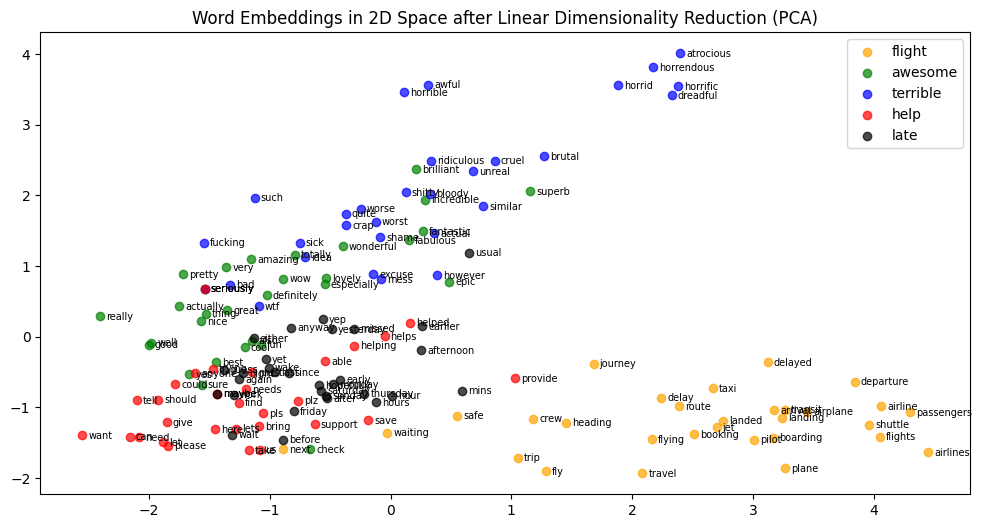

In [ ]:
# Extract feature vectors (embeddings) from DataFrame
X = np.vstack(result_df['Embedding'].values)

#Create PCA instance with 2 remaining dimensions
pca = PCA(n_components=2)

# Perform PCA to data
X_pca = pca.fit_transform(X)

seed_words = ["flight", "awesome", "terrible", "help", "late"]
seed_word_colors = ["orange", "green", "blue", "red", "black"]

# Plot 2D embeddings
plt.figure(figsize=(12, 6))
for i, seed_word in enumerate(seed_words):
    indices = result_df[result_df['Seed Word'] == seed_word].index
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], color=seed_word_colors[i], label=seed_word, alpha=0.7)
for i, row in result_df.iterrows():
    plt.annotate(row['Similar Word'], (X_pca[i, 0]+0.05, X_pca[i, 1]-0.05), size=7)

plt.title('Word Embeddings in 2D Space after Linear Dimensionality Reduction (PCA)')
plt.legend()

**Question**
Do you see five distinct clusters in the 2-d visualization produced by PCA? Please comment on the separation or lack thereof you observe from the visualization.

In the 2D visualization, more or less 5 clusters can be observed. However there are differences between how much the clusters differentiate from another. The most separated, is the orange cluster, representing the words similar to "flight". Also, the words similar to the seed word "terrible" are at least half separated from the rest of the words. Especially the black and red, but also the green and and blue clusters have a big overlap. This makes sense to me, since the respective seed words "late" and "help" and their neighbors may occur in similar situations, when help is needed due to a late departure of a plane or other public transport(e.g. due to a missed connecting flight). For green and blue, representing the seed words "awesome" and "terrible" the overlap may occur because of the fact, that both of these words are adjectives. However, it may also be a result of underfitting (i.e. the 2D representation cannot capture the complexities in the data), since the words are very different in their meanings, representing very good and very bad states of mind.


### 1.2.2. t-SNE (20pts)

Next you will apply a nonlinear embedding method t-SNE (you can use sklearn.manifold.TSNE with Euclidean distance) to reduce the dimension of the 150 words to 2-d and visualize them using the same color mapping. Note that Perplexity is a critical parameter for t-SNE. It is recommended by the authors of t-SNE that the perplexity value should be between 5 and 50. For this assignment, please consider different perplexity values including 5, 10, 20, 30, 40, and 50.

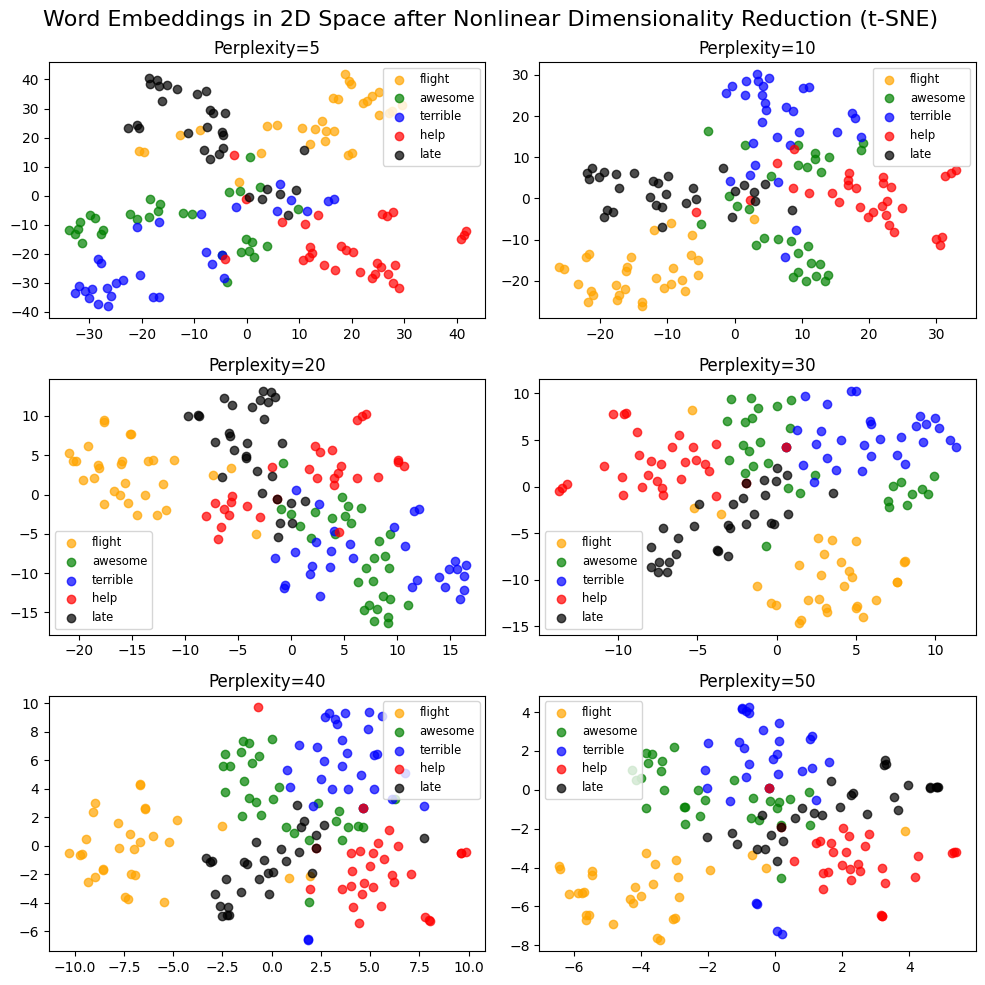

In [ ]:
# Perplexity values to consider
perplexities = [5, 10, 20, 30, 40, 50]

# Create subplots for each perplexity value
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

for i, perplexity in enumerate(perplexities):
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, metric='euclidean', random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Scatter plot with color mapping
    for j, seed_word in enumerate(seed_words):
        indices = result_df[result_df['Seed Word'] == seed_word].index
        axes[i].scatter(X_tsne[indices, 0], X_tsne[indices, 1], color=seed_word_colors[j], label=seed_word, alpha=0.7)

    # Set title and legend
    axes[i].set_title(f'Perplexity={perplexity}')
    axes[i].legend(fontsize='small')

plt.suptitle('Word Embeddings in 2D Space after Nonlinear Dimensionality Reduction (t-SNE)', fontsize=16)
# Adjust layout
plt.tight_layout()
plt.show()

**Question**
Do you see distinct clusters in the 2-d visualizations produced by t-SNE? Please comment on the separation or lack thereof that you observe from the visualization for different perplexity value. How does the perplexity parameter influence the results?

I can see clusters in the 2D visualizations, however in some cases they are not very distinctive, in others the clusters are relatively widespread and only half or less of the words are clearly separated from the other clusters. For example, the orange group of words is again mostly separated from the other groups of words, no matter what the perplexity value is. That makes sense, since "flight" is a specific word and its similar words are probably also related to the specific context of aviation. In contrast, again green and blue have big areas of overlaps, especially for perplexity parameter values of 5,10,20 and 50. However, Black and red are better separated than after PCA. Instead, black has a bigger overlap with the green and blue clusters, which makes sense only partially (green and black overlap is not expected since they represent words similar to the seed words "awesome" and "late")
Basically, there is no trend recognizable for me, considering the separation of the clusters and varying the perplexity parameter. The distances within the clusters decrease just like the distances between the different clusters as the perplexity value increases, meaning that neither a positive nor a negative trend can be seen by varying incresing the perplexity parameter.

## 1.3 Clustering the words (35pts)

### 1.3.1. Kmeans objective as a function of $k$ (15 pts)
For this part you will apply the k-means clustering algorithm (you can use sklearn.cluster.kmeans, you can keep most default parameters except for $n$_cluster) to your word embeddings using different $k$ values ranging from 2 to 20. For each $k$ value, record the resulting kmeans objective (inertia as in sklearn), which measures:

$$
\sum_{i=1}^k\sum_{x\in C_i} \|x - \mu_i\|^2
$$

Plot the kmeans objective as a function of $k$.



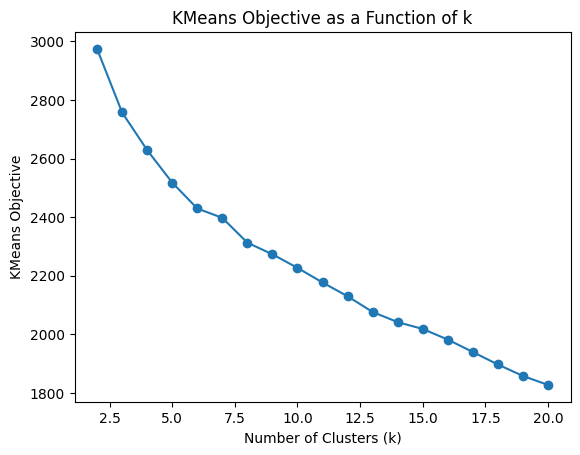

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min

# Range of k values
k_values = list(range(2, 21))

# List to store kmeans objective values
kmeans_objectives = []

# Applying k-means for different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k,n_init=10)
    kmeans.fit(X)
    kmeans_objectives.append(kmeans.inertia_)

# Plotting the kmeans objective as a function of k
plt.plot(k_values, kmeans_objectives, marker='o')
plt.title('KMeans Objective as a Function of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('KMeans Objective')
plt.show()


**Question:**
Do you observe monotonically decreasing objective value as we increase $k$? Do you see any evidence from this curve that suggests $k=5$?  Provide an explanation for your observations.

We observe a monotically decreasing objective value as k increases. I don't see any evidence suggesting k=5. However, I do see evidence that suggests k=7 since this is the knee point in the curve, which represents a heuristic approach to select k. Probably the missing evidence for k=5 is a result of the overlap of the words belonging to different seed words we already observed in part 1.2, where for example the words similar to "terrible" and "awesome" had non neglegibly large areas of overlaps. Also, there were some words located far away from the rest of the words in that cluster which possibly form its own cluster when aplying kmeans. Hence, we probably observe the knee point for k=7 and not for k=5.

###1.3.2 Evaluation metrics (20 pts)
Using the original seed word as ground truth labels for clustering, please evaluate the clustering solution for different $k$ values using different metrics including:

- Purity (you will need to implement this measure.)
- Adjusted rand index (you can use sklearn.metrics.adjusted\_rand\_score) and
- Normalized Mutual Information (you can use sklearn.metrics.normalized\_mutual\_info\_score).


Plot each metric you get as a function of $k$.




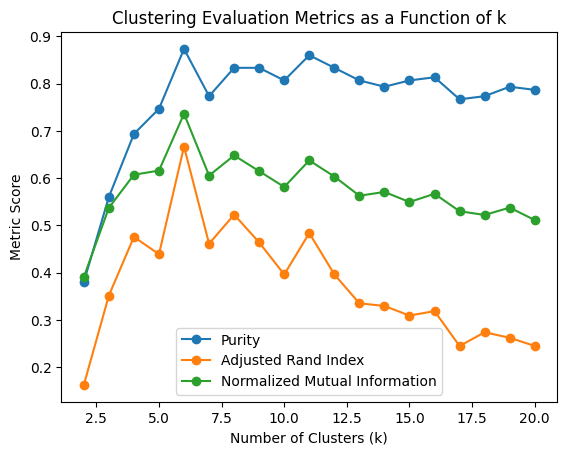

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix

# Range of k values
ground_truth_labels = np.zeros(150)
ground_truth_labels[30:60] = 1
ground_truth_labels[60:90] = 2
ground_truth_labels[90:120] = 3
ground_truth_labels[120:150] = 4

# Lists to store evaluation metrics
purity_scores = []
adjusted_rand_scores = []
normalized_mutual_info_scores = []

# Applying k-means for different k values and evaluating metrics
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    labels_pred = kmeans.fit_predict(X)

    # Calculate purity
    cm = contingency_matrix(ground_truth_labels, labels_pred)
    purity_scores.append(np.sum(np.amax(cm, axis=0))/np.sum(cm))
    # Calculate adjusted rand index
    adjusted_rand = adjusted_rand_score(ground_truth_labels, labels_pred)
    adjusted_rand_scores.append(adjusted_rand)

    # Calculate normalized mutual information
    nmi = normalized_mutual_info_score(ground_truth_labels, labels_pred)
    normalized_mutual_info_scores.append(nmi)

# Plotting evaluation metrics as a function of k
plt.plot(k_values, purity_scores, label='Purity', marker='o')
plt.plot(k_values, adjusted_rand_scores, label='Adjusted Rand Index', marker='o')
plt.plot(k_values, normalized_mutual_info_scores, label='Normalized Mutual Information', marker='o')

plt.title('Clustering Evaluation Metrics as a Function of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Metric Score')
plt.legend()
plt.show()

**Question:**
1. Does $k=5$ give the best score for different metrics? Provide an explanation for your observation.
2. Which of these three metrics are appropriate to use if we are evaluating two different clustering algorithms that automatically search for the number of clusters in the data (that is, one algorithm might find five clusters in the data while the other might find ten)?

1. For Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) k=5 gives the best result. For Purity however, the value stays large for all k values >=5, with its maximum for k=19.

  Explanation: Since the true number of clusters (each belonging to one seed word) is 5, it would make sense to me if the kmeans algorithm performed best with k=5. Both, the ARI and NMI, are metrics to show how well the predicted labels match the true labels. Thus, it makes sense that their value is the highest for k=5.
  For purity however, if the predicted number of clusters is greater than the true number of clusters, it is may be artificially high because the algorithm has more opportunities to assign instances to clusters. This overestimation can inflate the purity value.



2. When comparing two different clustering algorithms that automatically determine the number of clusters and might produce different numbers of clusters, both the Adjusted Rand Index and Normalized Mutual Information are appropriate metrics. These metrics are designed to handle situations where the number of clusters varies between different clustering solutions. In contrast purity is not a good metric: Like stated above, if the predicted number of clusters is greater than the true number of clusters, purity may be artificially high. Conversely, if the predicted number of clusters is smaller than the true number of clusters, purity may be artificially low because the algorithm may struggle to capture the complexity of the data. This leads to big differences between the results of different clustering algorithms when using purity as a evaluation metric.


# Part 2 (Optional): Using word embeddings to improve classification (25 Bonus pts)


For this bonus part, you will work with the sentiment classification dataset used in IA3 and conduct a somewhat open ended exploration to answer the following question:

How can you improve the bag-of-words representation for classification using the word embeddings?

Note that we are not looking for deep-learning based approaches. Rather, I am inviting you to think creatively about using the classifiers that we learned in this class so far but try to also leverage the word embeddings to improve the representation for the tweets so that the classification performance can be improved.

Here are some basic ideas to get you started.  

1. A tweet is a collecion of words. Instead of using BoW representation like we did in IA3, we can take the weighted average of the embeddings of the words in the tweet as a representation for the tweet. The embedding of a word can be weighted by the (normalized) tf-idf value for that word. This will greatly reduce the dimension of the tweet compared to the BoW representation, which can potentially reduce overfitting.

2. In BoW representation, we have the issue that words of similar meaning are treated as completely distinct. To see why this is a problem, consider "good trip" and "pleasant journey", they mean the same thing but in BoW representation they have nothing in common.  One possible way to address this is to group words in the vocabulary into clusters (e.g., "good" and "pleasant" will be in the same cluster whereas "trip" and "journey" will be in the same
cluster), and use Bag-of-word-clusters representation. In this case, the two phrases will have identical representation. This will substantially reduce the dimension and redundancy of the features.

You can pick one of these ideas, or try some of your own ideas. For classifier, you can experiment with any classifiers that have been covered in this class.  You only need to focus on one core idea in your exploration to get the bonus points. Also you are not required to get improved performance compared to IA3.  In addtion to provide the code for your exploration, you will also need to provide a brief report that clearly
*   describes your idea (and any hyperparameters/variants you have explored around that idea),
*   discusses the results (the training and validation performances),  
*   provides your interpretation of the results (e.g., how does your method influence the model's ability/tendency to overfit or underfit compared to the standard BoW method).  

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from collections import defaultdict

In [ ]:
train_path = '/content/gdrive/My Drive/AI534/IA3-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = '/content/gdrive/My Drive/AI534/IA3-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)

In [ ]:
train_data

,sentiment,text
0,0,@united who is in charge of making decisions over there? Cancelled Flightling flight UA1150 was unacceptable. I should be in #...
1,0,"@united great decision making skills flight ops IAH bag makes a 10 minute connection and I don't, flight pushed early. Disappo..."
2,0,@AmericanAir so what if I didn't have the funds to purchase another ticket? Your error would cause my family to miss the funeral
3,0,@united My flying United is over...sorry. The Captain still had 20 minutes of pre-flight preparations to make while we sat wit...
4,0,@united I believe just customer service. At last post he was at Narita in Tokyo. They sent him to a motel to rest. Said standb...
...,...,...
8995,1,@SouthwestAir your flight attendants are really funny!! The sass is giving me life!!! 😂
8996,1,"@VirginAmerica Love the team running Gate E9 at LAS tonight. Waited for a delayed flight, and they kept things entertaining"
8997,0,@SouthwestAir really shouldn't offer sweeps if your link isn't going to work! B http://t.co/nOfG0TQHYN
8998,0,@united no HUMAN contact for 2 mths from @AmericanAir cust relations or refund dept. If ever a problem do u have humans I can ...


In [ ]:
!python -m spacy download en_core_web_md

2023-12-09 07:25:29.643484: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 07:25:29.643542: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 07:25:29.643579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 07:25:29.651218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 07:25:30.745118: W tensorflow/c

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import spacy



In [ ]:
 # Convert to numpy
train_words = train_data["text"].to_numpy()
val_words = val_data["text"].to_numpy()
# Tf-idf representation
tfidf = TfidfVectorizer(stop_words='english')
train_fit = tfidf.fit_transform(train_words)
val_fit = tfidf.transform(val_words)
# Save lists of
word_list = {}
for i, ele2 in enumerate(tfidf.vocabulary_):
  word_list[tfidf.vocabulary_[ele2]] = ele2

In [ ]:
saver = []
for i in tqdm(range(len(train_words))):
  idf_col = train_fit[i,:]
  saver.append(idf_col.nonzero()[1])
saver_val = []
for i in tqdm(range(len(val_words))):
  idf_col = val_fit[i,:]
  saver_val.append(idf_col.nonzero()[1])

100%|██████████| 2500/2500 [00:00<00:00, 5192.05it/s]


In [ ]:
train_embeded_data = []
# Embedding for a word
for i, tweet in tqdm(enumerate(saver)):
  tweet_text = [word_list.get(wordd) for wordd in tweet]
  returned_embedings = ge.embed_list(tweet_text)
# print(returned_embedings.shape)
# break
  embeds = np.zeros(200)
  for j, word in enumerate(tweet):
# Embeding of a single word
# First conver
# Tfid of a single word
    tfid_value = train_fit[i,word]
    embeds = np.add(embeds, np.dot(returned_embedings[j][:], tfid_value))
  train_embeded_data.append(np.multiply(embeds, 1/len(tweet)))
val_embeded_data = []
# Embedding for a word
for i, tweet in tqdm(enumerate(saver_val)):
  tweet_text = [word_list.get(wordd) for wordd in tweet]
  returned_embedings = ge.embed_list(tweet_text)
# print(returned_embedings.shape)
# break
  embeds = np.zeros(200)
  for j, word in enumerate(tweet):
# Embeding of a single word
# First convert word to string
# Tfid of a single word
    tfid_value = val_fit[i,word]
    embeds = np.add(embeds, np.dot(returned_embedings[j][:], tfid_value))
  val_embeded_data.append(np.multiply(embeds, 1/len(tweet)))

9000it [00:10, 885.44it/s] 
2500it [00:02, 1154.36it/s]


In [ ]:
PCA_vals = [10, 50]
results = pd.DataFrame(columns=['PCA Dimensions', 'C-value', 'Training Accuracy', 'Validation Accuracy'])

def run_linear_svm(train_data_in, train_truth, val_data_in, val_truth, c_array, NUM_PCA):
  train_score = np.zeros(len(c_array), dtype = float)
  num_sv = np.zeros(len(c_array), dtype = float)
  val_score = np.zeros(len(c_array), dtype = float)
  new_results = pd.DataFrame(columns = ['PCA Dimensions', 'C-value', 'Training Accuracy', 'Validation Accuracy'])

  for i, c_val in enumerate(c_array):
    clf = SVC(kernel = 'linear', C = c_val)
    clf.fit(train_data_in, train_truth)
    train_score[i] = clf.score(train_data_in, train_truth)
    num_sv[i] = clf.support_vectors_.shape[0]
    val_score[i] = clf.score(val_data_in, val_sent)
    new_results = pd.concat([new_results, pd.DataFrame({'PCA Dimensions': [NUM_PCA] * len(c_array),
                                                        'C-value': c_array,
                                                        'Training Accuracy': train_score,
                                                        'Validation Accuracy': val_score})], ignore_index = True)
  return train_score, num_sv, val_score, new_results

def create_c_list(start, end, number):
  return np.power(np.ones(number) * 10, np.linspace(start, end, number))

for NUM_PCA in PCA_vals:
  pca = PCA(n_components=NUM_PCA)
  train_sent = train_data["sentiment"].to_numpy(dtype = np.int32)
  df_features_train = pd.DataFrame(data = train_sent, columns = ['target'])
  val_sent = val_data["sentiment"].to_numpy(dtype = np.int32)
  df_features_val = pd.DataFrame(data = val_sent, columns = ['target'])

  whisk = pca.fit_transform(train_embeded_data)
  whisk_val = pca.transform(val_embeded_data)
  C = create_c_list(-3, 3, 7)

  train_score, num_sv, val_score, new_results = run_linear_svm(whisk, train_sent, whisk_val, val_sent, C, NUM_PCA)
  results = pd.concat([results, new_results], ignore_index=True)

results

,PCA Dimensions,C-value,Training Accuracy,Validation Accuracy
0,10,0.001,0.796333,0.7908
1,10,0.010,0.000000,0.0000
2,10,0.100,0.000000,0.0000
3,10,1.000,0.000000,0.0000
4,10,10.000,0.000000,0.0000
...,...,...,...,...
93,50,0.100,0.874333,0.8804
94,50,1.000,0.899333,0.9004
95,50,10.000,0.902556,0.9052
96,50,100.000,0.902667,0.9044


In the initial run, we obtained impressive results without parameter tuning. By applying PCA to reduce dimensions to 10 and using a C-value of 1 for the SVM, we achieved remarkable accuracies of 88% on the training set and 89% on the validation set. The close proximity of these accuracies indicates that the model is not overfitting.

Further exploration involved varying C-values while keeping PCA fixed at 10. Surprisingly, regardless of the C-values (ranging from -3 to 3), the validation accuracy consistently mirrored the training accuracy. This suggests that the new representation, involving the weighted average of embeddings, exhibits a significantly lower inclination to overfit compared to the traditional Bag-of-Words representation.

Subsequently, we experimented with increasing the dimensionality to 50 using PCA instead of 10. However, across all C-values, the rise in accuracy was marginal, around 1% (e.g., 89% to 90%). Importantly, similar to the previous scenario, training and validation accuracies maintained a direct correspondence, indicating a lack of overfitting.

In [ ]:

!jupyter nbconvert --to pdf "/content/gdrive/MyDrive/Colab Notebooks/IA4.ipynb"

[NbConvertApp] WARNING | pattern '/content/gdrive/MyDrive/Colab Notebooks/IA4.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterAp